In [1]:
%matplotlib inline

import os
from math import log2

import ipywidgets as widgets
from ipywidgets import interact, interactive
from IPython.display import display

from create_feature_file import getSimNumber
from plot_atn_csv import *

Score functions
===============

Original environment score function
-----------------------------------

The environment score depends on:
- the number of species
- the following species-specific attributes:
    - total biomass
    - individual biomass
    - number of individuals (total biomass / individual biomass)
    - trophic level

In [2]:
def environmentScore(speciesData, nodeConfig, biomassData):
    """
    Compute the Ecosystem Score for all timesteps for the given data and return
    the score time series.  The calculations are taken from
    model.Ecosystem.updateEcosystemScore() in WoB_Server.
    """

    numTimesteps = len(biomassData[nodeConfig[0]['nodeId']])b
    scores = np.empty(numTimesteps)

    for timestep in range(numTimesteps):

        # Calculate the Ecosystem Score for this timestep
        biomass = 0
        numSpecies = len(nodeConfig)
        for node in nodeConfig:
            nodeId = node['nodeId']
            perUnitBiomass = node['perUnitBiomass']

            # Sometimes biomass can go slightly negative.
            # Clip to 0 to avoid complex numbers in score calculation.
            totalBiomass = max(0, biomassData[nodeId][timestep])

            biomass += perUnitBiomass * pow(totalBiomass / perUnitBiomass,
                    speciesData[nodeId]['trophicLevel'])
        if biomass > 0:
            biomass = round(log2(biomass)) * 5
        scores[timestep] = int(round(pow(biomass, 2) + pow(numSpecies, 2)))

    return scores

SyntaxError: invalid syntax (<ipython-input-2-cdb4fbfaf1dc>, line 8)

Original environment score, without rounding
---

$$Score_t = \left( 5 log_2 \left( \sum_{i=1}^N b_i \left(\frac{B_{it}}{b_i}\right)^{T_i} \right) \right)^2 + N^2$$

In [ ]:
def environmentScoreNoRounding(speciesData, nodeConfig, biomassData):

    numTimesteps = len(biomassData[nodeConfig[0]['nodeId']])
    scores = np.empty(numTimesteps)

    for timestep in range(numTimesteps):

        # Calculate the Ecosystem Score for this timestep
        biomass = 0
        numSpecies = len(nodeConfig)
        for node in nodeConfig:
            nodeId = node['nodeId']
            perUnitBiomass = node['perUnitBiomass']

            # Sometimes biomass can go slightly negative.
            # Clip to 0 to avoid complex numbers in score calculation.
            totalBiomass = max(0, biomassData[nodeId][timestep])

            biomass += perUnitBiomass * pow(totalBiomass / perUnitBiomass,
                    speciesData[nodeId]['trophicLevel'])
        if biomass > 0:
            biomass = log2(biomass) * 5
        scores[timestep] = pow(biomass, 2) + pow(numSpecies, 2)

    return scores

Using cube root instead of log
---

In [ ]:
def environmentScoreCubeRoot(speciesData, nodeConfig, biomassData):
    """
    Compute the Ecosystem Score for all timesteps for the given data and return
    the score time series.  The calculations are taken from
    model.Ecosystem.updateEcosystemScore() in WoB_Server.
    """

    numTimesteps = len(biomassData[nodeConfig[0]['nodeId']])
    scores = np.empty(numTimesteps)

    for timestep in range(numTimesteps):

        # Calculate the Ecosystem Score for this timestep
        biomass = 0
        numSpecies = len(nodeConfig)
        for node in nodeConfig:
            nodeId = node['nodeId']
            perUnitBiomass = node['perUnitBiomass']

            # Sometimes biomass can go slightly negative.
            # Clip to 0 to avoid complex numbers in score calculation.
            totalBiomass = max(0, biomassData[nodeId][timestep])

            biomass += perUnitBiomass * pow(totalBiomass / perUnitBiomass,
                    speciesData[nodeId]['trophicLevel'])
        if biomass > 0:
            biomass = pow(biomass, 1/3) * 5
        scores[timestep] = pow(biomass, 2) + pow(numSpecies, 2)

    return scores

Shannon index, based on number of individuals
---

In [ ]:
def shannonIndex(speciesData, nodeConfig, biomassData):
    numTimesteps = len(biomassData[nodeConfig[0]['nodeId']])
    scores = np.zeros(numTimesteps)
    
    for timestep in range(numTimesteps):
        individualCount = np.empty(len(nodeConfig))
        for i, node in enumerate(nodeConfig):
            speciesBiomass = max(0, biomassData[node['nodeId']][timestep])
            individualBiomass = node['perUnitBiomass']
            individualCount[i] = speciesBiomass / individualBiomass
        totalIndividuals = individualCount.sum()
        for i, node in enumerate(nodeConfig):
            if individualCount[i] == 0:
                continue
            proportion = individualCount[i] / totalIndividuals
            scores[timestep] -= proportion * log2(proportion)
    
    return scores

Shannon index, based on biomass
---

In [ ]:
def shannonIndexBiomass(speciesData, nodeConfig, biomassData):
    numTimesteps = len(biomassData[nodeConfig[0]['nodeId']])
    scores = np.zeros(numTimesteps)
    
    for timestep in range(numTimesteps):
        speciesBiomass = np.empty(len(nodeConfig))
        for i, node in enumerate(nodeConfig):
            speciesBiomass[i] = max(0, biomassData[node['nodeId']][timestep])
        totalBiomass = speciesBiomass.sum()
        for i, node in enumerate(nodeConfig):
            if speciesBiomass[i] <= 0:
                continue
            proportion = speciesBiomass[i] / totalBiomass
            scores[timestep] -= proportion * log2(proportion)
    
    return scores

Biomass-based Shannon index times total biomass
---

In [ ]:
def shannonIndexBiomassProduct(speciesData, nodeConfig, biomassData):
    numTimesteps = len(biomassData[nodeConfig[0]['nodeId']])
    scores = np.zeros(numTimesteps)
    
    for timestep in range(numTimesteps):
        speciesBiomass = np.empty(len(nodeConfig))
        for i, node in enumerate(nodeConfig):
            speciesBiomass[i] = max(0, biomassData[node['nodeId']][timestep])
        totalBiomass = speciesBiomass.sum()
        for i, node in enumerate(nodeConfig):
            if speciesBiomass[i] <= 0:
                continue
            proportion = speciesBiomass[i] / totalBiomass
            scores[timestep] -= proportion * log2(proportion)
        scores[timestep] *= totalBiomass
    
    return scores

Net production
---

In [4]:
def totalBiomass(speciesData, nodeConfig, biomassData):
    """
    Return a time series of the total biomass of all species
    """
    numTimesteps = len(biomassData[nodeConfig[0]['nodeId']])
    totalBiomass = np.empty(numTimesteps)
    for timestep in range(numTimesteps):
        totalBiomass[timestep] = sum([biomass[timestep] for biomass in biomassData.values()])
    return totalBiomass

def netProduction(speciesData, nodeConfig, biomassData):
    B = totalBiomass(speciesData, nodeConfig, biomassData)
    netProd = B - np.roll(B, 1)
    
    # Can't really say that net production was equal to total biomass at t0
    netProd[0] = netProd[-1] = 0
    
    return netProd

Select score function and plot
---

/home/ben/SFSU/fall2015/897 Research/atn-data/plot_atn_csv.py:80: RuntimeWarning: divide by zero encountered in log
  t, np.log(scores))
/home/ben/SFSU/fall2015/897 Research/atn-data/plot_atn_csv.py:80: RuntimeWarning: invalid value encountered in log
  t, np.log(scores))


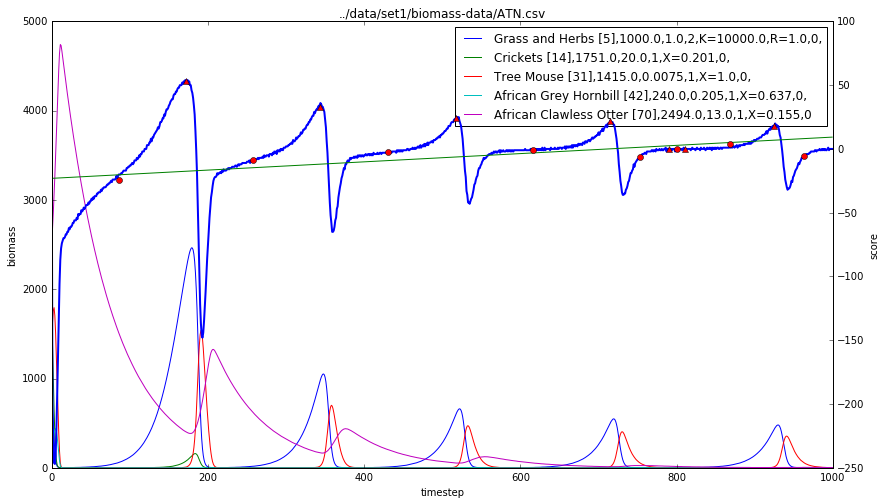

TREND MEASURES:
sum of derivative: 0.0
linear regression: slope = 0.03235314835314835, intercept = -23.0543976023976
log-linear regression: slope = nan, intercept = nan
regionAverages[-2] - regionAverages[1] = 12.654970760233919
regionAverages[-2] / regionAverages[1] = -0.4024627349319507
average (excluding first timestep): -6.900900900900901

SPECIES DATA:
{
    "5": {
        "K": 10000.0,
        "R": 1.0,
        "initialBiomass": 1000.0,
        "name": "Grass and Herbs",
        "nodeId": 5,
        "perUnitBiomass": 1.0,
        "trophicLevel": 1.0
    },
    "14": {
        "X": 0.201,
        "initialBiomass": 1751.0,
        "name": "Crickets",
        "nodeId": 14,
        "perUnitBiomass": 20.0,
        "trophicLevel": 2.125
    },
    "31": {
        "X": 1.0,
        "initialBiomass": 1415.0,
        "name": "Tree Mouse",
        "nodeId": 31,
        "perUnitBiomass": 0.0075,
        "trophicLevel": 2.38095
    },
    "42": {
        "X": 0.637,
        "initialBiomass":

In [5]:
scoreFunction = netProduction

csvDir = '../data/set1/biomass-data'
filenames = os.listdir(csvDir)
filenames.sort(key=lambda f: getSimNumber(f))

def plotFile(filename):
    plotCsv(os.path.join(csvDir, filename), scoreFunction)

selectWidget = interactive(plotFile, filename=widgets.Select(description="File", options=filenames))
display(selectWidget)


Net production trend
---
It seems strange that the net production trend tends to be slightly positive.
The plot below demonstrates how the derivative of an exponentially decaying function has an upward trend.

For net production, the average is 

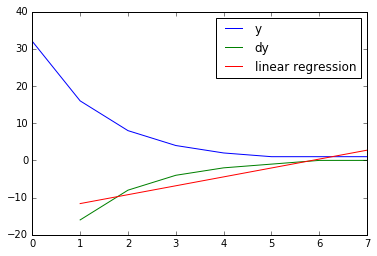

In [6]:
y = np.array([32, 16, 8, 4, 2, 1, 1, 1])
x = np.arange(len(y))
dy = (y - np.roll(y, 1))[1:]
plt.plot(x, y, label='y')
plt.plot(x[1:], dy, label='dy')

slope, intercept, r_value, p_value, std_err = stats.linregress(x[1:], dy)
plt.plot(x[1:], x[1:] * slope + intercept, label='linear regression')

plt.legend()